In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
#Act = pd.read_csv("atusact_0323.dat")
Resp=pd.read_csv("atusresp_0323.dat")
Raster=pd.read_csv("atusrost_0323.dat")

In [126]:
# vars interested in 
respondent_vars = ['TUCASEID', 'TRTALONE', 'TRNUMHOU', 'TRSPPRES', 'TELFS', 'TEHRUSL1', 'TRTSPONLY', 'TRTFAMILY', 'TEIO1OCD']
roster_vars = ['TUCASEID', 'TEAGE', 'TESEX'] 

Dependent:
TRTALONE: Total time (in minutes) the respondent spent alone, excluding sleep.

Predictors used:

TUCASEID: Unique identifier for each household.
TRNUMHOU: Number of people living in the respondents household.
TELFS: Labor force status of the respondent.
1 Employed - at work
2 Employed - absent
3 Unemployed - on layoff
4 Unemployed - looking
5 Not in labor force
TEHRUSL1: Average number of hours per week the respondent usually works at their 
main job.

TRSPPRES: Presence of the respondents spouse or unmarried partner in the household, coded as follows:
1: Spouse present
2:Unmarried partner present
3:No spouse or partner present
TRTFAMILY: Total time (in minutes) the respondent spent with family members, excluding work-related activities.
TRTSPONLY: Total time (in minutes) the respondent spent exclusively with their spouse, excluding work-related activities.
TESEX: Sex of the respondent.
TEAGE: Age of the respondent. 
TEIO1OCD (occupation code for the respondent's main job)



In [127]:
# Subset the data to the variables of interest
respondent_subset = Resp[respondent_vars]
roster_subset = Raster[roster_vars]
# Merge the files on the ID column
merged_df = pd.merge(respondent_subset, roster_subset, on='TUCASEID', how='inner')
# I am investigating only for the adults 
adults_df = merged_df[merged_df['TEAGE'] >= 18]

#take a random sample as the data is huge 
sampled_df = adults_df.sample(n=1000, random_state=42)  # random_state for reproducibility

final_df = sampled_df.drop_duplicates(subset='TUCASEID')


Data Exploration 

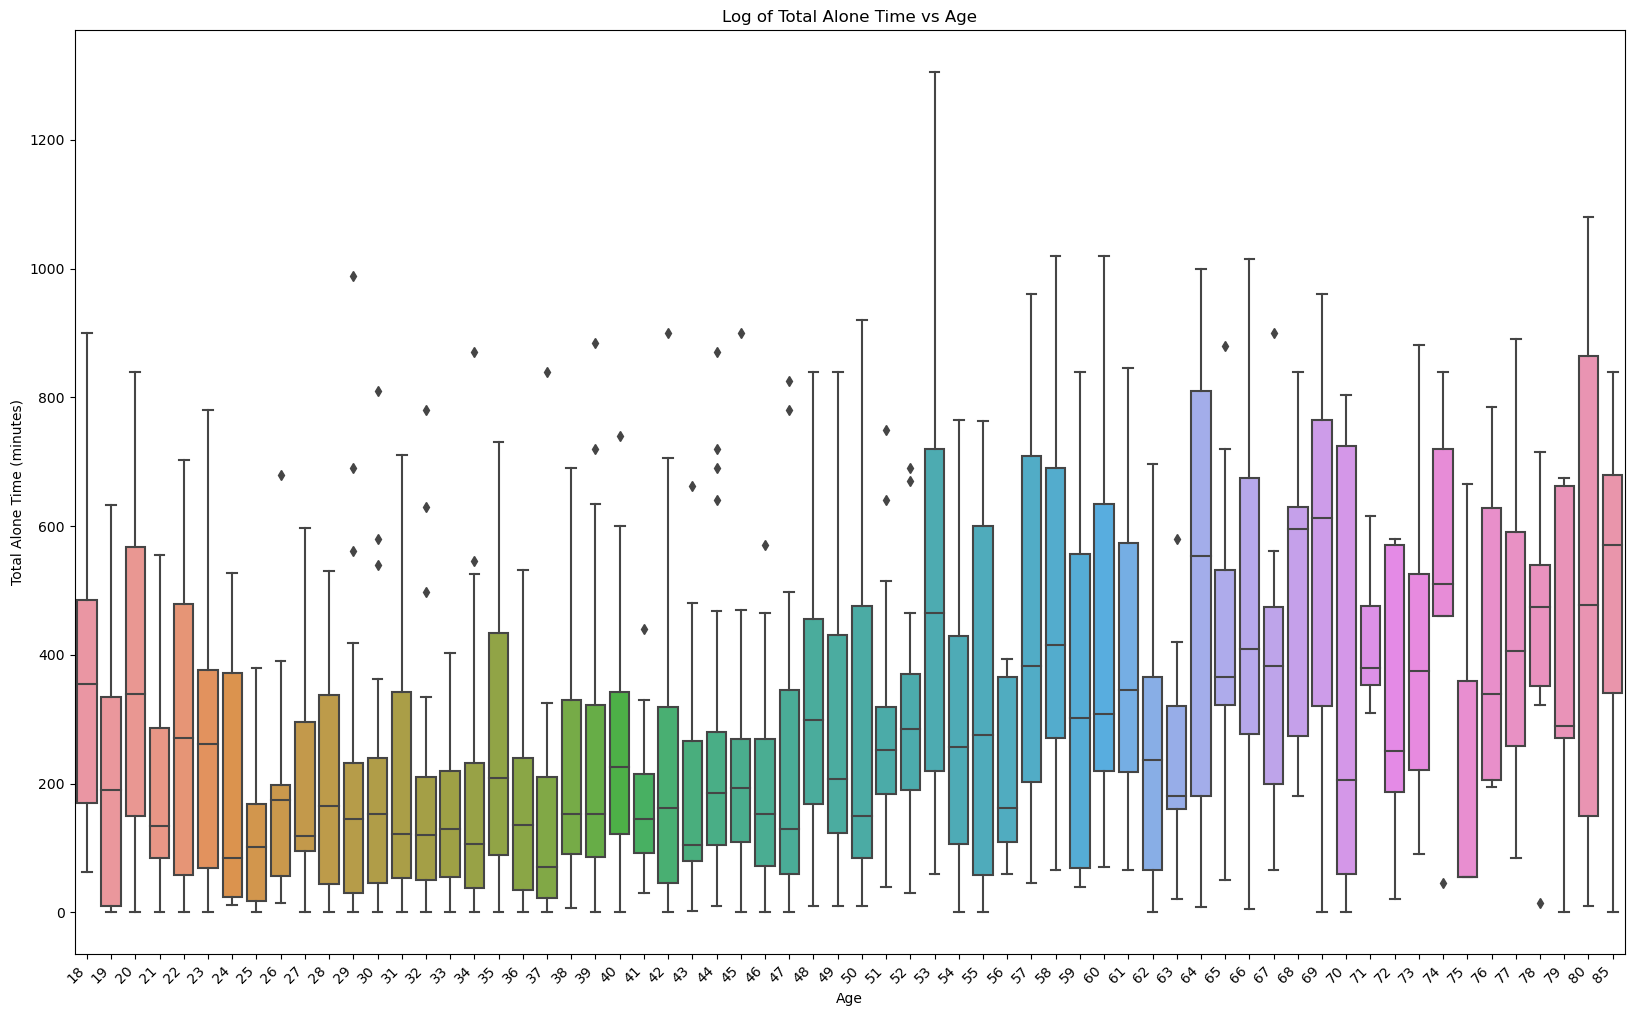

In [98]:
# Distribtuion of Total Alone Time by Age 

plt.figure(figsize=(20, 12))

sns.boxplot(data=final_df, x='TEAGE', y='TRTALONE')
plt.title('Log of Total Alone Time vs Age')
plt.xlabel('Age')
plt.ylabel('Total Alone Time (minutes)')
plt.xticks(rotation=45, ha='right')
plt.show()



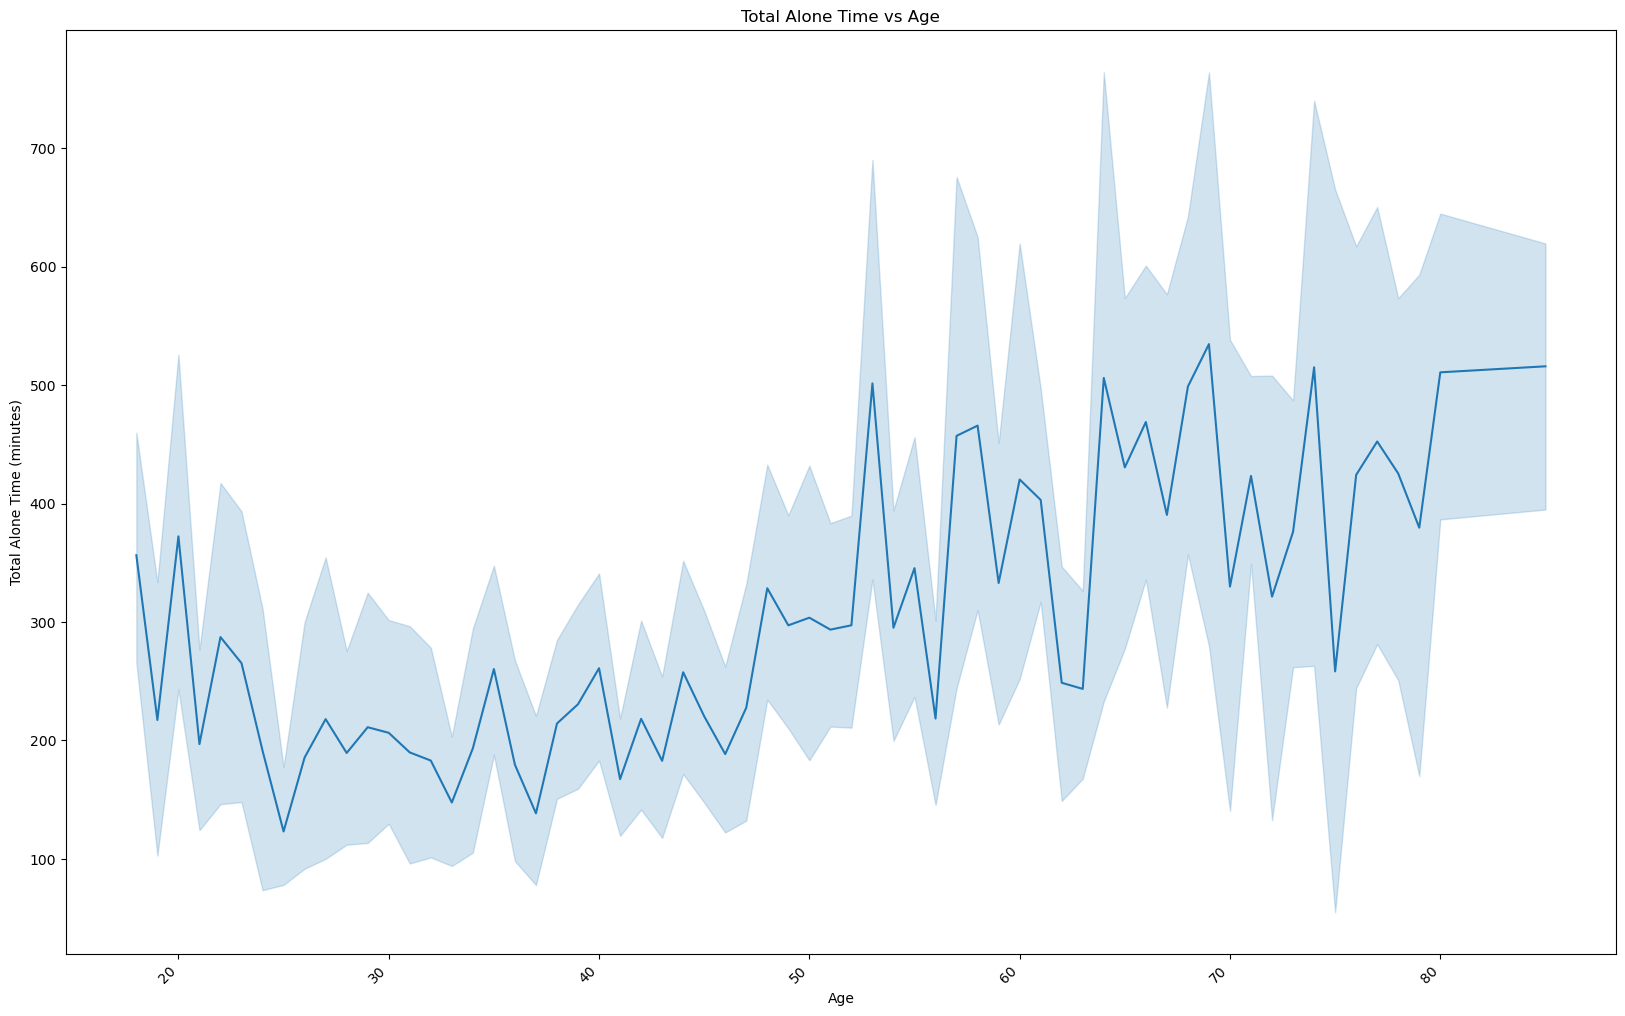

In [112]:
# Distribtuion of Total Alone Time by Age 

plt.figure(figsize=(20, 12))

sns.lineplot(data=final_df, x='TEAGE', y='TRTALONE')
plt.title('Total Alone Time vs Age')
plt.xlabel('Age')
plt.ylabel('Total Alone Time (minutes)')
plt.xticks(rotation=45, ha='right')
plt.show()



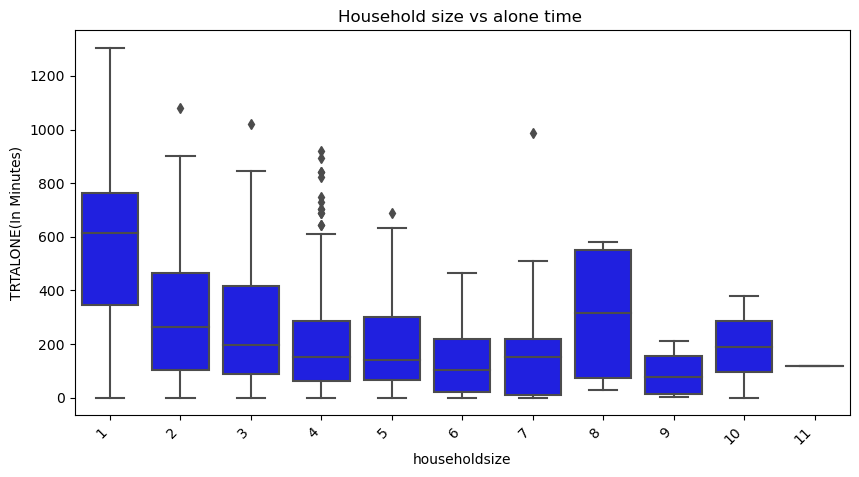

In [88]:
# Number of people living in the respondents household vs alone time 

plt.figure(figsize=(10, 5))

sns.boxplot(data=final_df, x='TRNUMHOU', y='TRTALONE', color='blue')

plt.title('Household size vs alone time ')
plt.xlabel('householdsize')
plt.ylabel('TRTALONE(In Minutes)')
plt.xticks(rotation=45, ha='right')

plt.show()

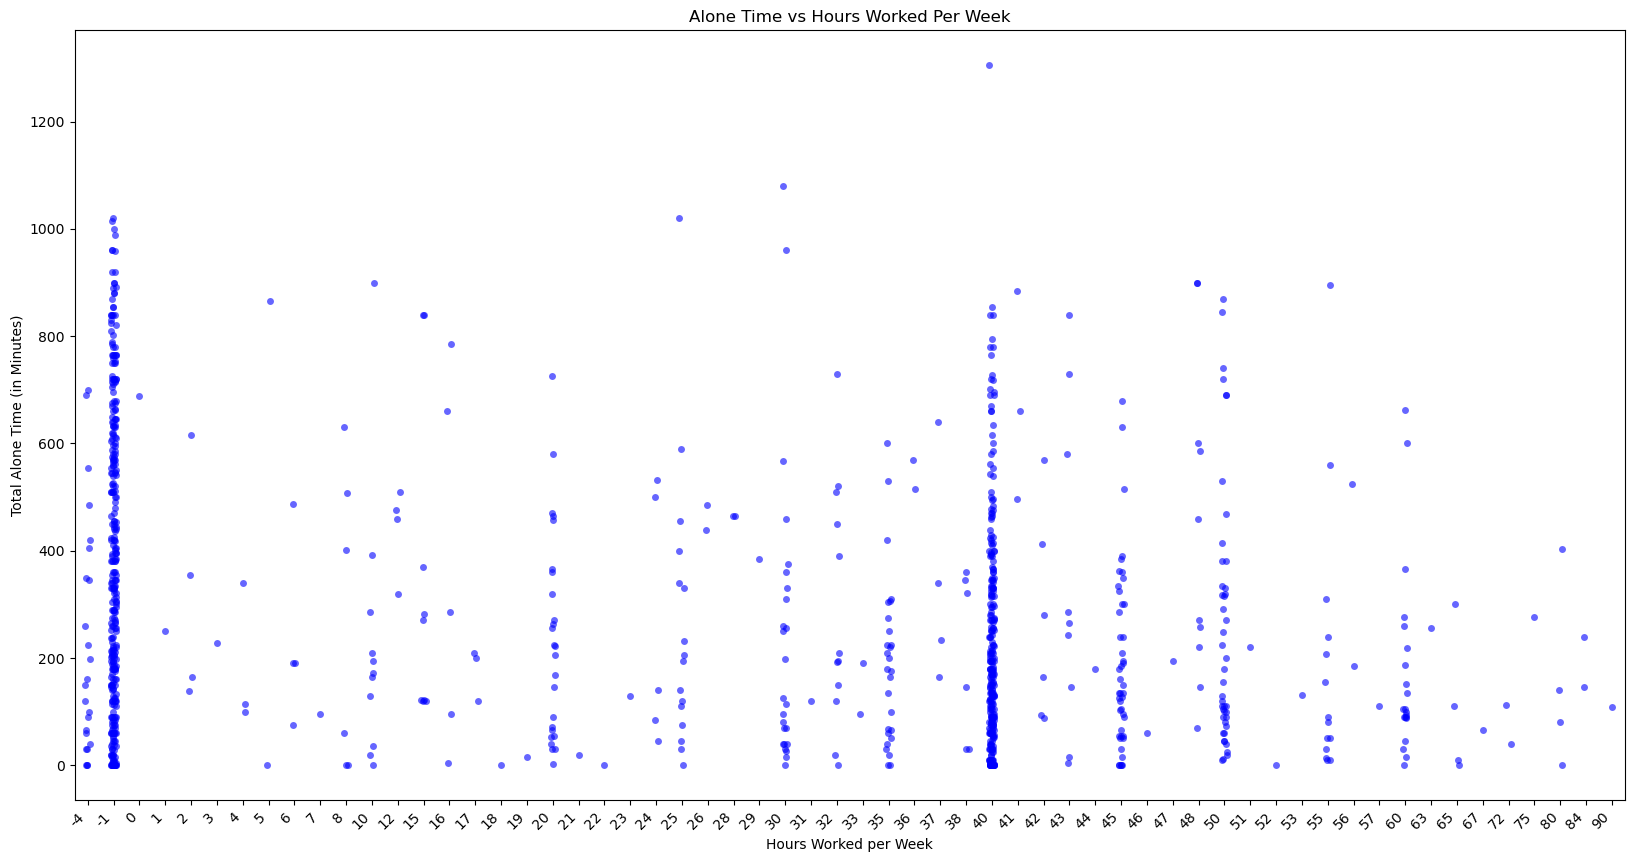

In [113]:
#Average Number of Hours Per Week the Respondent Usually Works at Their Main Job vs Alone Time

plt.figure(figsize=(20, 10))

#  with jitter
sns.stripplot(data=final_df, x='TEHRUSL1', y='TRTALONE', color='blue', jitter=True, alpha=0.6)

plt.title('Alone Time vs Hours Worked Per Week')
plt.xlabel('Hours Worked per Week')
plt.ylabel('Total Alone Time (in Minutes)')

plt.xticks(rotation=45, ha='right')

plt.show()

#

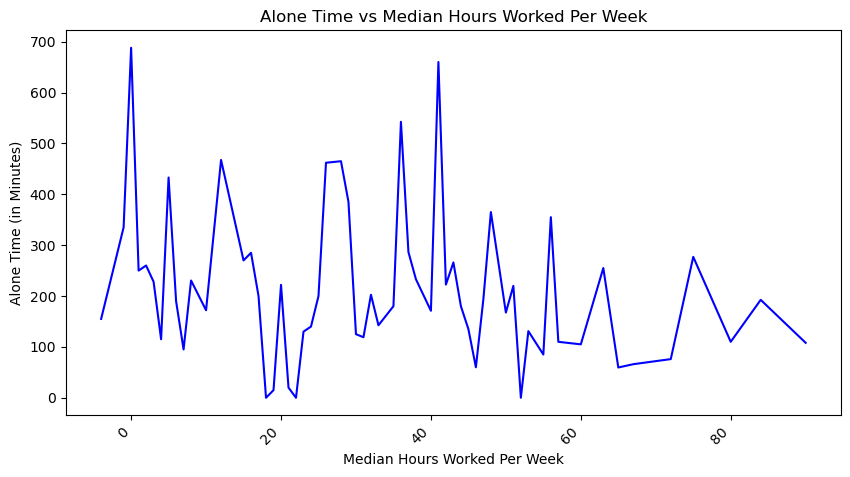

In [122]:
#Average Number of Hours Per Week the Respondent Usually Works at Their Main Job vs Alone Time

plt.figure(figsize=(10, 5))
sns.lineplot(data=median_df, x='TEHRUSL1', y='TRTALONE', color='blue', estimator='median')

# Title and labels
plt.title('Alone Time vs Median Hours Worked Per Week')
plt.xlabel('Median Hours Worked Per Week')
plt.ylabel('Alone Time (in Minutes)')

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()


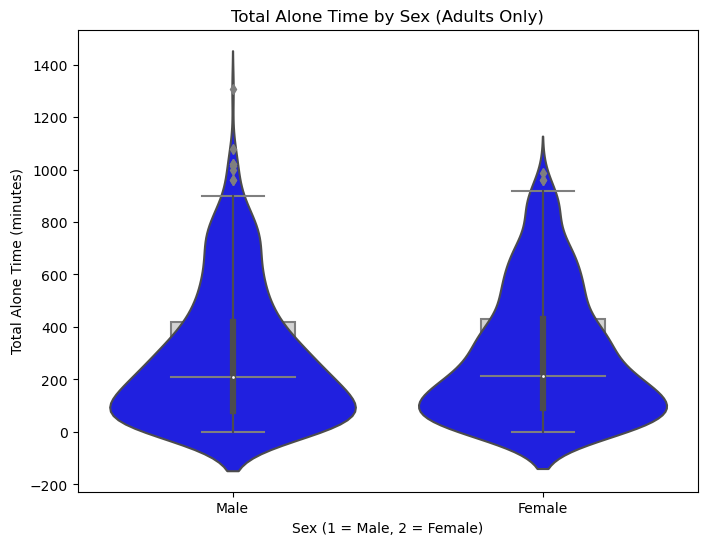

In [14]:
# boxplot for TRTALONE by TESEX
plt.figure(figsize=(8, 6))

sns.boxplot(data=final_df, x='TESEX', y='TRTALONE', color='lightgray', width=0.4)

# Overlay a violin plot
sns.violinplot(data=final_df, x='TESEX', y='TRTALONE', color='blue', alpha=0.5)

plt.title('Total Alone Time by Sex (Adults Only)')
plt.xlabel('Sex (1 = Male, 2 = Female)')
plt.ylabel('Total Alone Time (minutes)')
plt.xticks([0, 1], ['Male', 'Female'])  

plt.show()

In [ ]:
# boxplot for TRTALONE by TESEX
plt.figure(figsize=(8, 6))

sns.boxplot(data=final_df, x='TESEX', y='TRTALONE', color='lightgray', width=0.4)

# Overlay a violin plot
sns.violinplot(data=final_df, x='TESEX', y='TRTALONE', color='blue', alpha=0.5)

plt.title('Total Alone Time by Sex (Adults Only)')
plt.xlabel('Sex (1 = Male, 2 = Female)')
plt.ylabel('Total Alone Time (minutes)')
plt.xticks([0, 1], ['Male', 'Female'])  

plt.show()

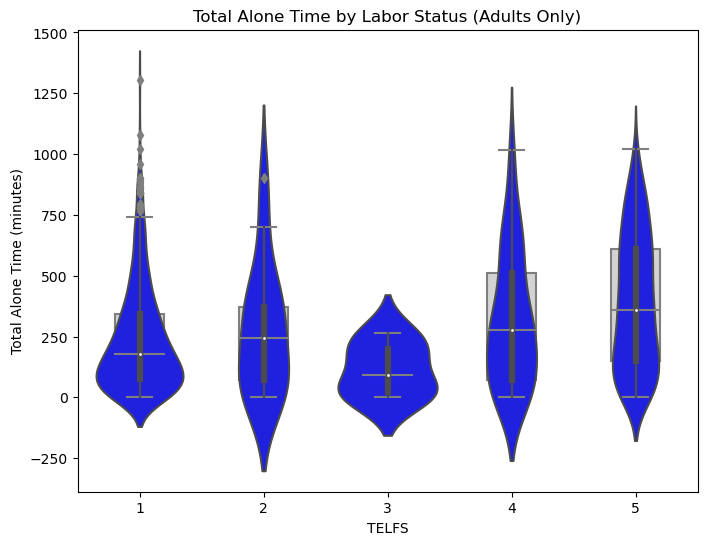

In [15]:
# boxplot for Total Alone Time by Labor Status (Adults Only)'
plt.figure(figsize=(8, 6))

# Create a boxplot
sns.boxplot(data=final_df, x='TELFS', y='TRTALONE', color='lightgray', width=0.4)

# Overlay a violin plot
sns.violinplot(data=final_df, x='TELFS', y='TRTALONE', color='blue', alpha=0.5)

# Customizing the plot
plt.title('Total Alone Time by Labor Status (Adults Only)')
plt.ylabel('Total Alone Time (minutes)')  # Setting labels for clarity

plt.show()

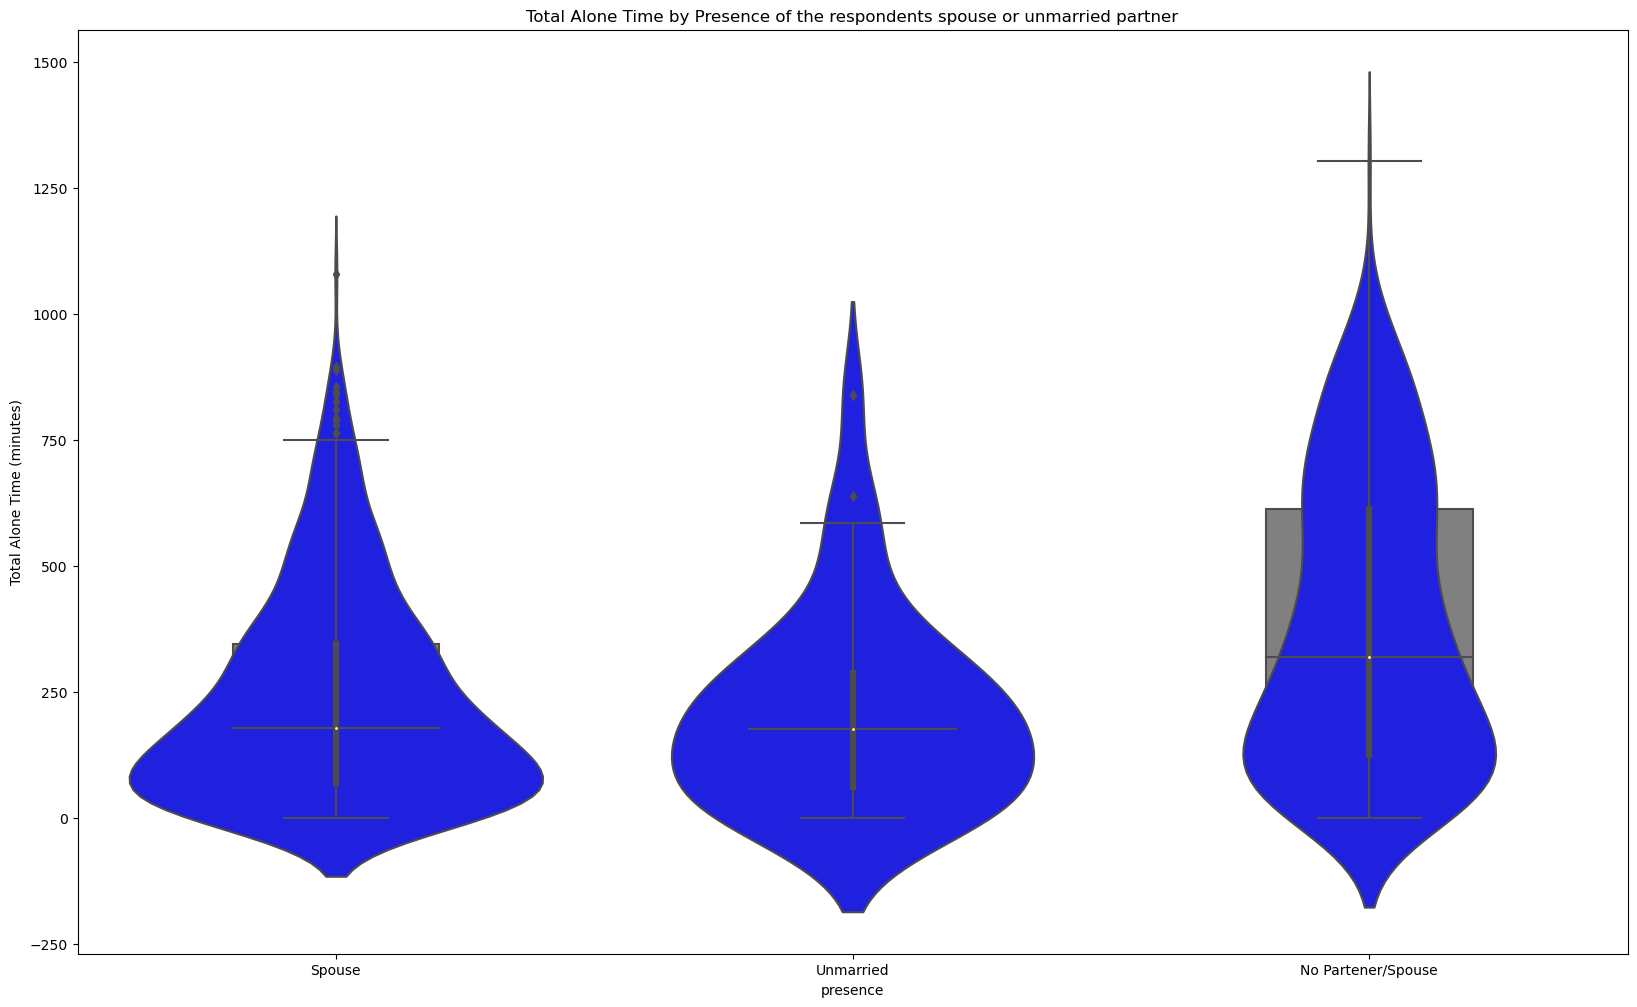

In [137]:
# boxplot for TRTALONE by TESEX
plt.figure(figsize=(20, 12))

sns.boxplot(data=final_df, x='TRSPPRES', y='TRTALONE', color='gray', width=0.4)

# violin plot
sns.violinplot(data=final_df, x='TRSPPRES', y='TRTALONE', color='blue', alpha=0.5)

plt.title('Total Alone Time by Presence of the respondents spouse or unmarried partner')
plt.xlabel('presence')
plt.ylabel('Total Alone Time (minutes)')
plt.xticks([0, 1, 2], ['Spouse', 'Unmarried', 'No Partener/Spouse'])  

plt.show()

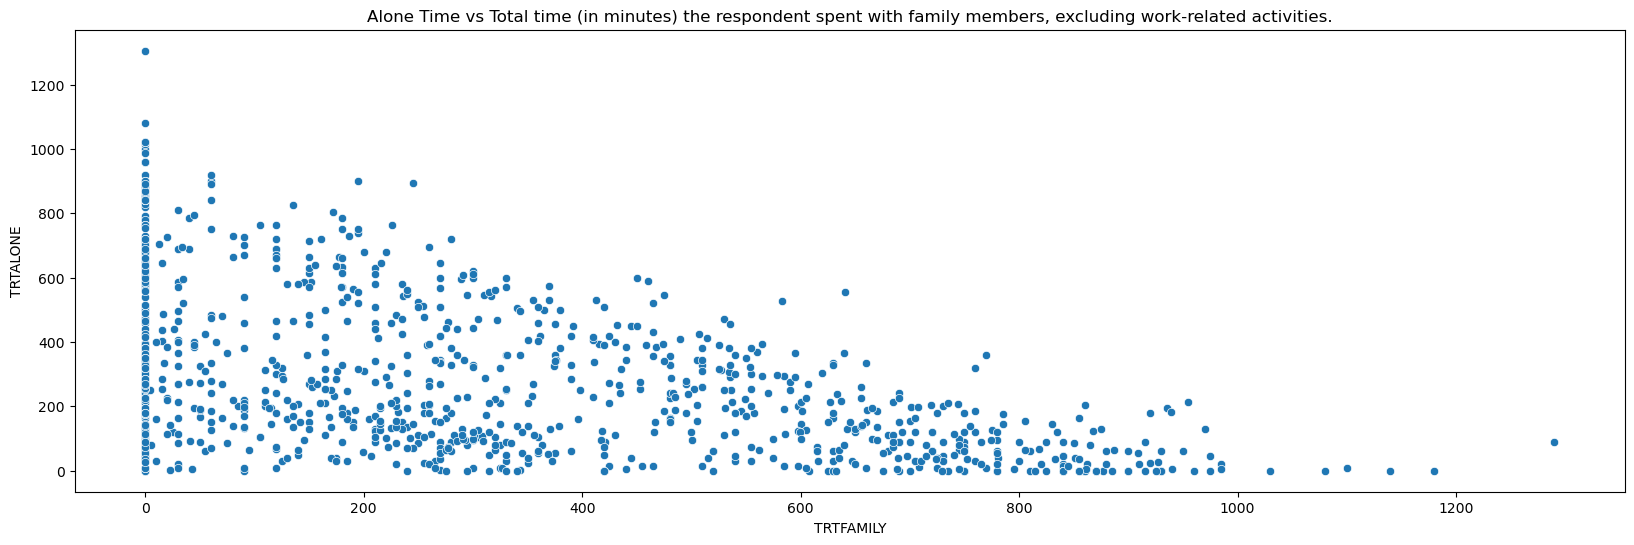

In [147]:
plt.figure(figsize=(20,6))

sns.scatterplot(data=final_df, x='TRTFAMILY', y='TRTALONE')
plt.title('Alone Time vs Total time (in minutes) the respondent spent with family members, excluding work-related activities.')

plt.show()

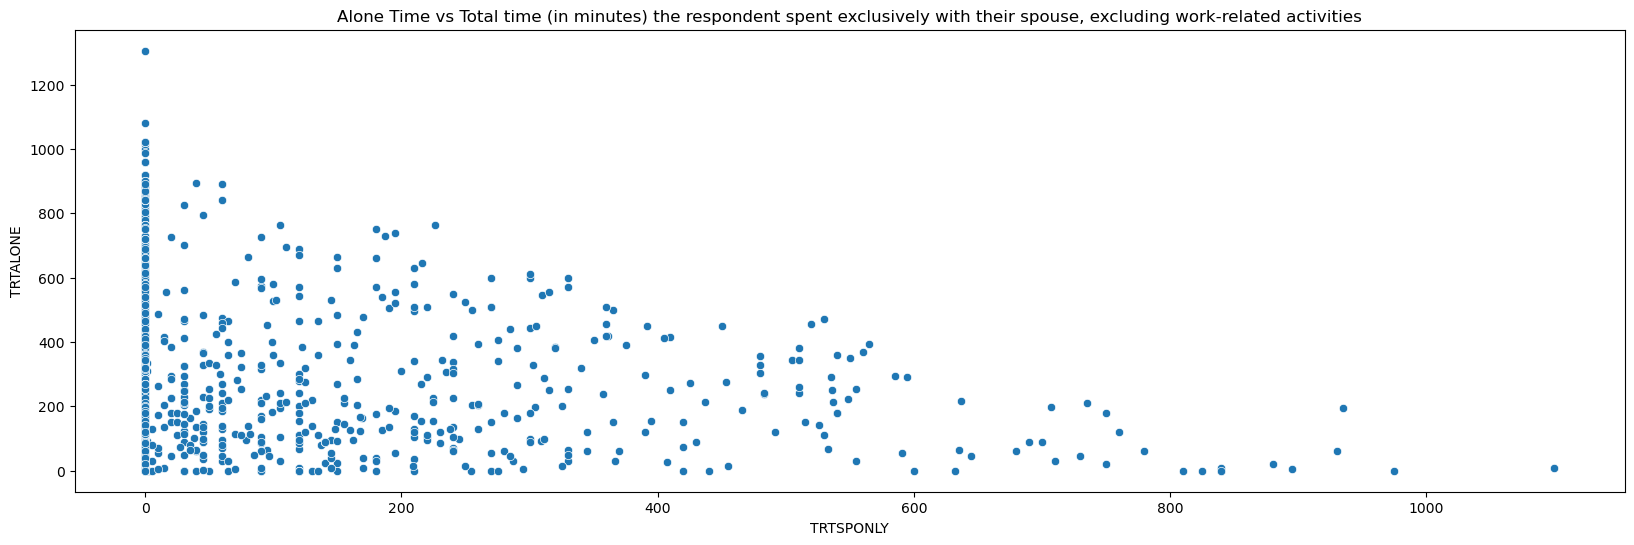

In [152]:
plt.figure(figsize=(20,6))

sns.scatterplot(data=final_df, x='TRTSPONLY', y='TRTALONE')
plt.title('Alone Time vs Total time (in minutes) the respondent spent exclusively with their spouse, excluding work-related activities')

plt.show()

In [75]:
# List of the predictor columns 

predictor_cols = ['TRNUMHOU', 'TRSPPRES', 'TELFS', 'TEHRUSL1', 'TRTSPONLY', 'TRTFAMILY', 'TEAGE', 'TESEX']

#  Df to store summary statistics
summary_stats = pd.DataFrame(columns=['Predictor', 'Mean', 'Median', 'Standard Deviation'])

# Calculate descriptive statistics for each predictor
for predictor in predictor_cols:
    stats = final_df.groupby(predictor)['TRTALONE'].agg(['mean', 'median', 'std']).reset_index()
    
    # Store the overall statistics in a new row for summary
    overall_stats = {
        'Predictor': predictor,
        'Mean': stats['mean'].mean(),
        'Median': stats['median'].median(),
        'Standard Deviation': stats['std'].mean() 
         
    }
    
    summary_stats = summary_stats.append(overall_stats, ignore_index=True)



/var/folders/2x/vtjgswgj6pj1xwzfpdt05jt40000gp/T/ipykernel_62859/4267882570.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_stats = summary_stats.append(overall_stats, ignore_index=True)
/var/folders/2x/vtjgswgj6pj1xwzfpdt05jt40000gp/T/ipykernel_62859/4267882570.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_stats = summary_stats.append(overall_stats, ignore_index=True)
/var/folders/2x/vtjgswgj6pj1xwzfpdt05jt40000gp/T/ipykernel_62859/4267882570.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_stats = summary_stats.append(overall_stats, ignore_index=True)
/var/folders/2x/vtjgswgj6pj1xwzfpdt05jt40000gp/T/ipykernel_62859/4267882570.py:21: FutureWarning: The frame.append method is deprecat

In [76]:
summary_stats

,Predictor,Mean,Median,Standard Deviation
0,TRNUMHOU,236.526047,153.00,214.183429
1,TRSPPRES,272.968905,180.00,228.850989
2,TELFS,266.299871,242.50,228.217393
3,TEHRUSL1,240.880685,191.25,197.419414
4,TRTSPONLY,221.076721,206.00,165.051882
5,TRTFAMILY,219.696311,176.00,141.474225
6,TEAGE,307.732405,231.00,233.691162
7,TESEX,285.312748,212.00,248.624098


In [156]:
#check for the correlation between the predictors 
# Select only the predictor columns
predictor_cols = ['TRNUMHOU', 'TRSPPRES', 'TELFS', 'TEHRUSL1', 'TRTSPONLY', 'TRTFAMILY', 'TEIO1OCD', 'TEAGE', 'TESEX']

# Calculate the correlation matrix for the predictor variables
correlation_matrix = final_df[predictor_cols].corr()

 

In [157]:
correlation_matrix 

,TRNUMHOU,TRSPPRES,TELFS,TEHRUSL1,TRTSPONLY,TRTFAMILY,TEIO1OCD,TEAGE,TESEX
TRNUMHOU,1.000000,-0.192303,-0.088721,0.061660,-0.155732,0.292783,0.032529,-0.410233,-0.033114
TRSPPRES,-0.192303,1.000000,0.155355,-0.196676,-0.453106,-0.429222,-0.026559,0.000516,0.071994
TELFS,-0.088721,0.155355,1.000000,-0.813738,0.116991,0.085492,-0.657052,0.326967,0.024854
TEHRUSL1,0.061660,-0.196676,-0.813738,1.000000,-0.110359,-0.105648,0.501019,-0.309012,-0.061313
TRTSPONLY,-0.155732,-0.453106,0.116991,-0.110359,1.000000,0.412246,-0.139820,0.276835,-0.049552
TRTFAMILY,0.292783,-0.429222,0.085492,-0.105648,0.412246,1.000000,-0.115718,-0.084930,0.026003
TEIO1OCD,0.032529,-0.026559,-0.657052,0.501019,-0.139820,-0.115718,1.000000,-0.245105,0.020859
TEAGE,-0.410233,0.000516,0.326967,-0.309012,0.276835,-0.084930,-0.245105,1.000000,-0.021293
TESEX,-0.033114,0.071994,0.024854,-0.061313,-0.049552,0.026003,0.020859,-0.021293,1.000000


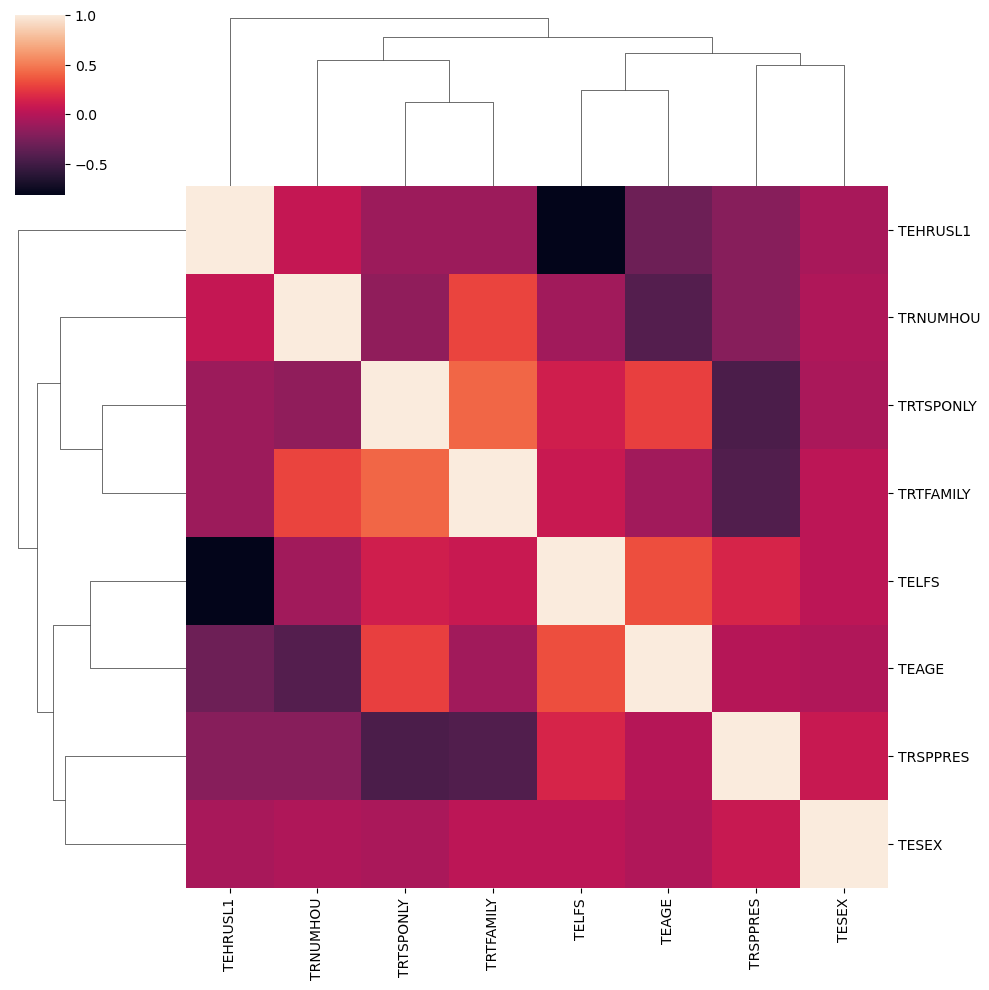

In [81]:
sns.clustermap(correlation_matrix )

In [82]:
# I am creating the YEAR column by extracting the first four digits of the TUCASEID as they correspond to the year 
final_df['YEAR'] = final_df['TUCASEID'].astype(str).str[:4].astype(int)



/var/folders/2x/vtjgswgj6pj1xwzfpdt05jt40000gp/T/ipykernel_62859/3198346521.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['YEAR'] = final_df['TUCASEID'].astype(str).str[:4].astype(int)


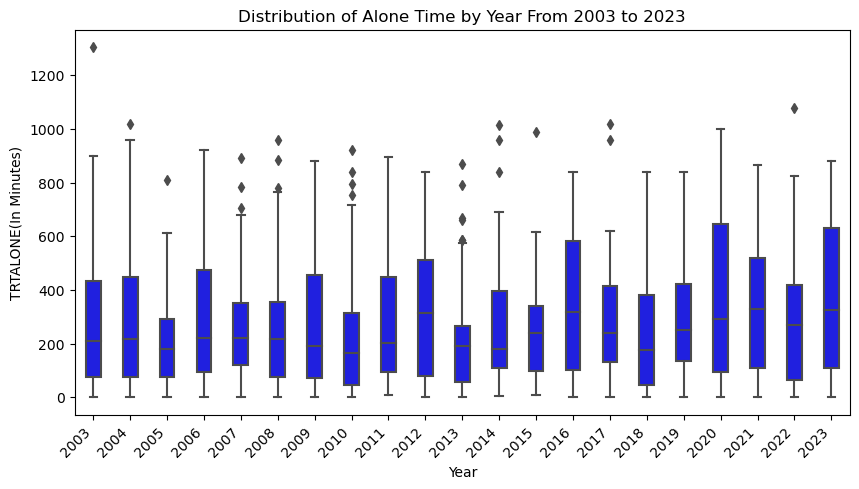

In [61]:
# Create a boxplot of 'TRTALONE' values grouped by 'YEAR'
plt.figure(figsize=(10, 5))


sns.boxplot(data=final_df, x='YEAR', y='TRTALONE', color='blue', width=0.4)

#final_df.boxplot(column='TRTALONE', by='YEAR', grid=True)

plt.title('Distribution of Alone Time by Year From 2003 to 2023')
plt.xlabel('Year')
plt.ylabel('TRTALONE(In Minutes)')
plt.xticks(rotation=45, ha='right')

plt.show()


In [158]:
final_df.to_csv('final_df.csv')

In [162]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [171]:
# feautures
X = final_df[['TRNUMHOU', 'TRSPPRES', 'TELFS', 'TEHRUSL1', 'TRTSPONLY', 'TRTFAMILY', 'TEIO1OCD', 'TEAGE', 'TESEX']]
y = final_df['TRTALONE'] # dependent
 

#Spliting the Data into Training and Testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the  Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make Predictions
y_pred = rf_model.predict(X_test)

# Evaluate the Model
mse = mean_squared_error(y_test, y_pred)
RMSE=rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the results
print('RMSE:', RMSE)
print('R-squared:', r2)

# Optionally, inspect feature importance
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
print('feature_importances:\n',  feature_importances.sort_values(ascending=False))


RMSE: 200.11648534339702
R-squared: 0.3685766093670757
feature_importances:
 TRTFAMILY    0.363781
TEAGE        0.193972
TEIO1OCD     0.137797
TEHRUSL1     0.121198
TRNUMHOU     0.101129
TRTSPONLY    0.034127
TRSPPRES     0.025820
TESEX        0.022176
dtype: float64


In [160]:
final_df.isna().mean()

TUCASEID     0.0
TRTALONE     0.0
TRNUMHOU     0.0
TRSPPRES     0.0
TELFS        0.0
TEHRUSL1     0.0
TRTSPONLY    0.0
TRTFAMILY    0.0
TEIO1OCD     0.0
TEAGE        0.0
TESEX        0.0
dtype: float64